
### Reference

- Digital Signal Processing Lecture
https://github.com/spatialaudio/digital-signal-processing-lecture

- Python for Signal Processing (unipingco)
https://github.com/unpingco/Python-for-Signal-Processing

- Audio for Deep Learning (남기현님)
https://tykimos.github.io/2019/07/04/ISS_2nd_Deep_Learning_Conference_All_Together/

- 오디오 전처리 작업을 위한 연습 (박수철님)
https://github.com/scpark20/audio-preprocessing-practice

- Musical Applications of Machine Learning
https://mac.kaist.ac.kr/~juhan/gct634/

- Awesome audio study materials for Korean (최근우님)
https://github.com/keunwoochoi/awesome-audio-study-materials-for-korean

## Digital Signal Processing

저희의 목적은 소리 signal를 어떠한 데이터 타입으로 표현하며, 소리와 관련된 task를 해결하는데 있습니다. 그렇다면 소리는 어떠한 데이터를 가지고 있을까요?

### Sound?

소리는 일반적으로 진동으로 인한 공기의 압축으로 생성됩니다. 그렇다면 압축이 얼마나 됬느냐에 따라서 표현되것이 바로 Wave(파동)인데요. 파동은 진동하며 공간/매질을 전파해 나가는 현상입니다. 질량의 이동은 없지만 에너지/운동량의 운반은 존재합니다.

Wave에서 저희가 얻을수 있는 정보는 크게 3가지가 있습니다.
- Phase(Degress of displacement) : 위상
- Amplitude(Intensity) : 진폭
- Frequency : 주파수


### Sampling

샘플링은 무엇일까요?? 아날로그 정보를 잘게 쪼개서 discrete한 디지털 정보로 표현해야합니다. 우리는 무한하게 쪼개서 저장할수 없으니, 어떤 기준을 가지고 아날로그 정보를 쪼개서 대표값을 취하게 됩니다.

```Convert into a sqeuence of binary values via Sampling and Quantization```

### 1.1. Time domain

시간을 기준으로 아날로그 시그널을 쪼개게 되는 것을 의미합니다. Sampling을 통하여 컴퓨터는 소리 sequence를 binary value로 받아드리게 됩니다.

__Sampling rate : 얼마나 잘게 쪼갤 것인가?__<br>
잘개 쪼갤수록 원본 데이터와 거이 가까워지기 떄문에 좋지만 Data의 양이 증가하게 됩니다. 만약 너무 크게 쪼개게 된다면, 원본 데이터로 reconstruct하기 힘들어 질 것입니다.



__Sampling theorem__<br>
샘플링 레이트가 최대 frequency의 2배 보다 커져야 한다는 것입니다.
$ f_{s} > 2f_{m} $ 여기서 $f_{s}$는 sampling rate, 그리고 $f_{m}$은 maximum frequency를 말합니다.

- Nyqusit frequency = $f_{s}/2$, sampling rate의 절반입니다.

일반적으로 Sampling은 인간의 청각 영역에 맞게 형성이 됩니다.
- Audio CD : 44.1 kHz(44100 sample/second)
- Speech communication : 8 kHz(8000 sample/second)

In [1]:
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchaudio

In [2]:
# tra
in_dataset = torchaudio.datasets.LIBRISPEECH("./", url="train-clean-100", download=True)
test_dataset = torchaudio.datasets.LIBRISPEECH("./", url="test-clean", download=True)

100%|██████████| 5.95G/5.95G [31:18<00:00, 3.40MB/s]   
100%|██████████| 331M/331M [01:30<00:00, 3.81MB/s]   


In [3]:
test_dataset[1]

#소리 데이터, 샘플레이트

(tensor([[ 0.0010,  0.0011,  0.0009,  ..., -0.0007, -0.0010, -0.0011]]),
 16000,
 'STUFF IT INTO YOU HIS BELLY COUNSELLED HIM',
 1089,
 134686,
 1)

In [4]:
test_dataset[0][0].shape

torch.Size([1, 166960])

In [5]:
audioData = test_dataset[1][0][0]
sr = test_dataset[1][1]
print(audioData, audioData.shape)

tensor([ 0.0010,  0.0011,  0.0009,  ..., -0.0007, -0.0010, -0.0011]) torch.Size([52400])


In [6]:
len(audioData)

52400

In [7]:
len(audioData) / sr #duration이 나옴

3.275

In [8]:
import IPython.display as ipd
ipd.Audio(audioData, rate=sr)


### Resampling

샘플링된 데이터를 다시금 더 높은 sampling rate 혹은 더 낮은 sampling rate로 다시 샘플링할수 있습니다. 이때는 일반적으로 interpolation(보간)을 할때는 low-pass filter를 사용합니다.(Windowed sinc function)


In [9]:
y_8k = librosa.resample(y=audioData.numpy(), orig_sr=sr, target_sr=8000) #torch에서 바로 import 해서 tensor로 되어 있음 -> numpy 붙이기
ipd.Audio(y_8k, rate=8000)

In [10]:
len(y_8k)

26200

In [25]:
y_2k = librosa.resample(y=audioData.numpy(), orig_sr=sr, target_sr=4000)
ipd.Audio(y_2k, rate=4000)

In [26]:
len(y_2k)

13100

### Nomalization & Quantization

시간의 기준이 아닌 실제 amplitude의 real valued 를 기준으로 시그널의 값을 조절합니다. Amplitude를 이산적인 구간으로 나누고, signal 데이터의 Amplitude를 반올림하게 됩니다.

그렇다면 이산적인 구간은 어떻게 나눌수 있을까요?, bit의 비트에 의해서 결정됩니다.
- B bit의 Quantization : $-2^{B-1}$ ~ $2^{B-1}-1$
- Audio CD의 Quantization (16 bits) : $-2^{15}$ ~ $2^{15}-1$
- 위 값들은 보통 -1.0 ~ 1.0  영역으로 scaling되기도 합니다.


In [27]:
audio_np = audioData.numpy()
normed_wav = audio_np / max(np.abs(audio_np))
ipd.Audio(normed_wav, rate=sr)

In [28]:
#quantization 하면 음질은 떨어지지만 light한 자료형이 된다.
Bit = 8
max_value = 2 ** (Bit-1)

quantized_8_wav = normed_wav * max_value
quantized_8_wav = np.round(quantized_8_wav).astype(int)
quantized_8_wav = np.clip(quantized_8_wav, -max_value, max_value-1)
ipd.Audio(quantized_8_wav, rate=sr)

### mu-law encoding

사람의 귀는 소리의 amplitude에 대해 log적으로 반응합니다. 즉, 작은소리의 차이는 잘잡아내는데 반해 소리가 커질수록 그 차이를 잘 느끼지 못합니다. 이러한 특성을 wave값을 표현하는데 반영해서 작은값에는 높은 분별력(high resolution)을, 큰값끼리는 낮은 분별력(low resolution)을 갖도록 합니다

In [29]:
def mu_law(x, mu=255):
    return np.sign(x) * np.log(1 + mu * np.abs(x)) / np.log(1 + mu)

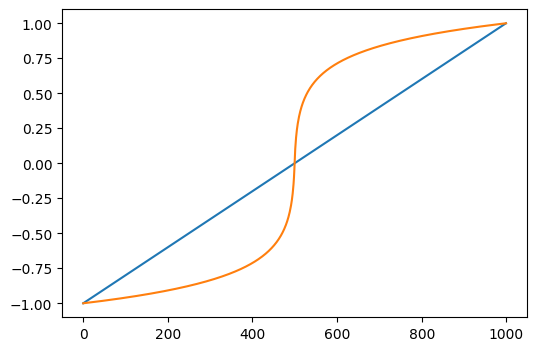

In [30]:
x = np.linspace(-1, 1, 1000)
x_mu = mu_law(x)

plt.figure(figsize=[6, 4])
plt.plot(x)
plt.plot(x_mu)
plt.show()

In [31]:
wav_mulaw = mu_law(normed_wav)
ipd.Audio(wav_mulaw, rate=sr)

## 2. Sound Representation

위에서 Sampling된 discrete한 데이터를 이제 우리는 표현이 가능합니다. 그렇다면 어떤 요소를 기반으로 저희가 데이터를 표현해야할까요?, 첫번째는 시간의 흐름에 따라, 공기의 파동의 크기로 보는 Time-domain Representation 방법이 있습니다. 두번째는 시간에 따라서 frequency의 변화를 보는 Time-Frequency representation이 있습니다.

### 2.1. Time domain - Waveform

Waveform의 경우에는 오디오의 자연적이 표현입니다. 시간이 x축으로 그리고 amplitude가 y축으로 표현이 됩니다.

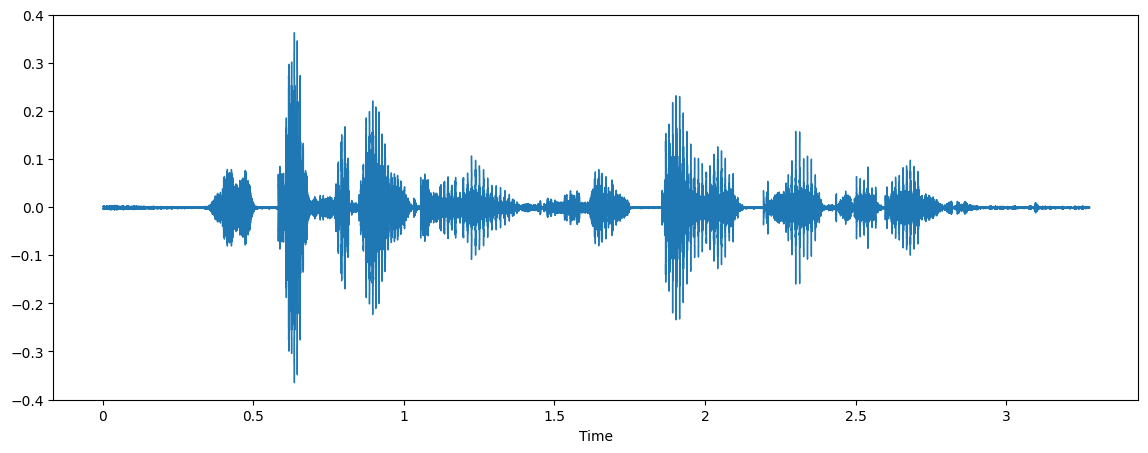

In [32]:
import librosa.display

audio_np = audioData.numpy() #-> numpy로 바꾸기

fig = plt.figure(figsize = (14,5))
librosa.display.waveshow(audio_np[0:100000], sr=sr)

### 정현파 (Sinusoid)

모든 신호는 주파수(frequency)와 크기(magnitude), 위상(phase)이 다른 정현파(sinusolida signal)의 조합으로 나타낼 수 있다. 퓨리에 변환은 조합된 정현파의 합(하모니) 신호에서 그 신호를 구성하는 정현파들을 각각 분리해내는 방법입니다.

In [33]:
A = 0.9
f = 340 # 계이름 '라'
phi = np.pi/2
fs = 22050
t = 1
#여러개의 정현파를 합치면 소리의 신호. 반대로 소리에서 정현파를 분리할 수 있다.

In [34]:
def Sinusoid(A,f,phi,fs,t):
    t = np.arange(0,t,1.0/fs)
    x = A * np.cos(2*np.pi*f*t+phi)
    return x

In [35]:
# 두 개의 정현파 생성
sin1 = Sinusoid(A=0.8, f=220, phi=0, fs=fs, t=t)     # 예: 220 Hz
sin2 = Sinusoid(A=0.9, f=340, phi=np.pi/2, fs=fs, t=t)  # 예: 340 Hz

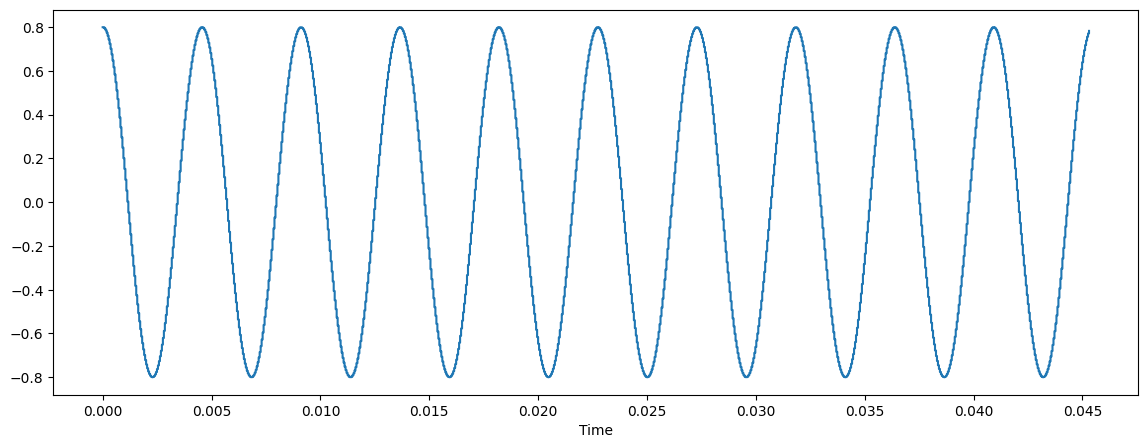

In [37]:
fig = plt.figure(figsize = (14,5))
librosa.display.waveshow(sin1[:1000], sr=fs)

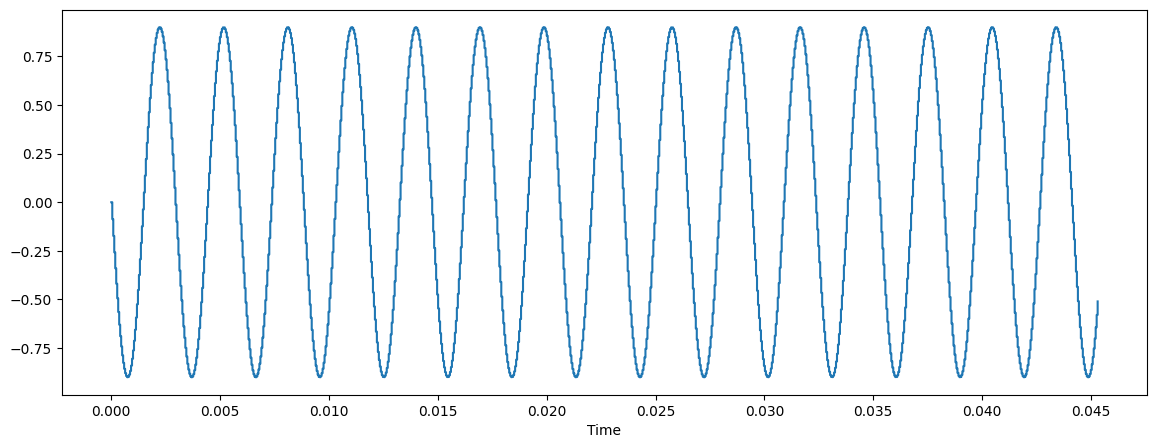

In [36]:
fig = plt.figure(figsize = (14,5))
librosa.display.waveshow(sin2[:1000], sr=fs)

In [38]:
complexwave = sin1  + sin2
complexwave = complexwave.astype(np.float32)  # librosa 시각화를 위해 float로 변환

/tmp/ipykernel_634615/3102830839.py:4: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_634615/3102830839.py:4: UserWarning: Glyph 54633 (\N{HANGUL SYLLABLE HAB}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_634615/3102830839.py:4: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_634615/3102830839.py:4: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE HYEON}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_634615/3102830839.py:4: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from current font.
  plt.tight_layout()
/home/elicer/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/elicer/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54633 

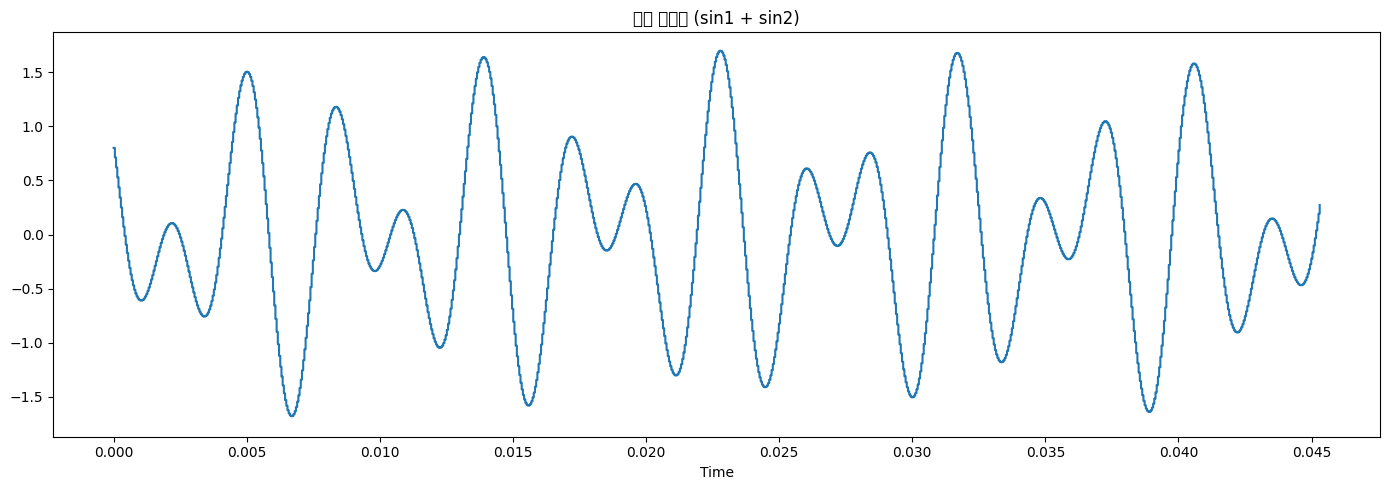

In [40]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(complexwave[:1000], sr=fs)
plt.title("복합 정현파 (sin1 + sin2)")
plt.tight_layout()
plt.show()

In [41]:
ipd.Audio(complexwave + complexwave/2 + complexwave/4, rate=fs)

In [42]:
def generate_sinusoid_scale(pitches=[69], duration=0.5, Fs=22050, amplitude_max = 0.5):
    N = int(duration * Fs)
    t = np.arange(N) / Fs
    x = []
    for p in pitches:
        omega = 2 ** (( p - 69 ) / 12 ) * 440
        x = np.append(x, np.sin(2 * np.pi * omega * t))
    x = amplitude_max * x/np.max(x)
    return x

duration = 1
Fs = 22050

pitches = [36,48,60,72,84,96]
x = generate_sinusoid_scale(pitches=pitches, duration=duration, Fs=Fs)
print('Pitch class C = {..., C1, C2, C3, C4, C5, C6, ...}', flush=True)
ipd.display(ipd.Audio(data=x, rate=Fs))

Pitch class C = {..., C1, C2, C3, C4, C5, C6, ...}


### 푸리에 변환 (Fourier transform)


푸리에 변환(Fourier transform)을 직관적으로 설명하면 푸리에 변환은 임의의 입력 신호를 다양한 주파수를 갖는 주기함수(복수 지수함수)들의 합으로 분해하여 표현하는 것 입니다. 그리고 각 주기함수들의 진폭을 구하는 과정을 퓨리에 변환이라고 합니다.

- 주기(period): 파동이 한번 진동하는데 걸리는 시간, 또는 그 길이, 일반적으로 sin함수의 주기는 $2\pi /w$입니다
- 주파수(frequency): 1초동안의 진동횟수입니다.

퓨리에 변환의 식을 살펴봅시다.

$$
y(t)=\sum_{k=-\infty}^\infty A_k \, \exp \left( i\cdot 2\pi\frac{k}{T} t \right)
$$

이 식을 하나식 해석해봅시다. $k$는 $-\infty ~ \infty$의 범위를 가지고 움직입니다. 이것은 주기함수들의 갯수입니다. 어떠한 신호가 다른 주기함수들의 합으로 표현되는데, 그 주기함수는 무한대의 범위에 있군요.

그렇다면 $A_k$은 그 사인함수의 진폭이라고 합니다. 이 식은 시간에 대한 입력신호 $y_{t}$가  $\exp \left( i\cdot 2\pi\frac{k}{T} t \right)$와 진폭($A_k$)의 선형결합으로 표현됨을 말하고 있군요.


위 그림을 본다면 조금 더 명확히 알수 있을 것 같습니다. 붉은색 라인이 입력신호 $y_{t}$ 입니다. 일반적으로 우리가 다루게 되는 데이터인 음악이나 목소리 같은 데이터 역시 complex tone입니다. 여려개의 주파수영역이 합쳐진 것이죠. 이러한 여러개의 주파수 영역을 분리하자!가 주요한 아이디어입니다. 파란색 주기함수들을 보신다면 여러개의 주기함수들을 찾으실 수 있습니다. 그 주기함수들은 고유의 주파수(frequency)와 강도(amplitude)를 가지고 있고 그것이 파란색의 라인들로 표현되어 있습니다.

진폭에 대한 수식은 다음과 같습니다.

$$
A_k = \frac{1}{T} \int_{-\frac{T}{2}}^\frac{T}{2} f(t) \, \exp \left( -i\cdot 2\pi \frac{k}{T} t \right) \, dt
$$

여기서 하나의 의문점이 드실것 같습니다. 주기함수의 합으로 표현된다고 했는데 저희가 보고 있는것은 $\exp \left( i\cdot 2\pi\frac{k}{T} t \right)$ 지수함수의 형태이기 때문입니다.

지수함수와 주기함수 사이의 연관관계는 무엇일까요? 그 관계를 찾은 것이 바로 오일러 공식입니다.

$$
e^{i\theta} = \cos{\theta} + i\sin{\theta}
$$

이 식을 위 식처럼 표현한다면 다음과 같습니다
$$
\exp \left( i\cdot 2\pi\frac{k}{T} t \right) = \cos\left({2\pi\frac{k}{T}}\right) + i\sin\left({2\pi\frac{k}{T}}\right)
$$

여기서 $\cos{2\pi\frac{k}{T}}$, $i\sin{2\pi\frac{k}{T}}$ 함수는 주기와 주파수를 가지는 주기함수입니다.

즉 퓨리에 변환은 입력 singal이 어떤것인지 상관없이 sin, cos과 같은 주기함수들의 합으로 항상 분해 가능하다는 것입니다.

### Fourier Transform의 Orthogonal

$$
y(t)=\sum_{k=-\infty}^\infty A_k \, \exp \left( i\cdot 2\pi\frac{k}{T} t \right)
$$

어떠한 주기함수를 우리는 cos과 sin함수로 표현하게 되었습니다. 여기서 한가지 재밌는 점은, 이 함수들이 직교하는 함수(orthogonal)라는 점이다.
$$
\{ \exp \left(i\cdot 2\pi\frac{k}{T} t\right) \} = orthogonal
$$

벡터의 직교는 해당 벡터를 통해 평면의 모든 좌표를 표현할수 있었다. 함수의 내적은 적분으로 표현할 수 있는데, 만약 구간 [a,b]에서 직교하는 함수는 구간 [a,b]의 모든 함수를 표현할수 있습니다.

위 케이스에서는 cos, sin 함수가 사실상 우리 입력신호에 대해서 기저가 되어주는 함수라고 생각할 수 있습니다.

### DFT (Discrete Fourier Transform)

한가지 의문점이 듭니다. 바로, 우리가 sampling으로 들어온 데이터는 바로 시간의 간격에 따른 소리의 amplitude의 discrete한 데이터이기 때문이다. 그렇다면 위 푸리에 변환 식을 Discrete한 영역으로 생각해봅시다.

만약에 우리가 수집한 데이터 $y_{n}$에서, 이산 시계열 데이터가 주기 $N$으로 반복한다고 할때, DFT는 주파수와 진폭이 다른 $N$개의 사인 함수의 합으로 표현이 가능합니다.
$$
y_n = \frac{1}{N} \sum_{k=0}^{N-1} Y_k \cdot \exp \left( i\cdot 2\pi\frac{k}{N} n \right)
$$

위 식을 보면 k의 range가 0부터 $N-1$로 변화했음을 알 수 있다. 이때 Spectrum $Y_{k}$를 원래의 시계열 데이터에 대한 퓨리에 변환값이라고 하죠.

$$
Y_k = \sum_{n=0}^{N-1} y_n\cdot \exp \left( -i\cdot 2\pi\frac{k}{N} n \right)
$$

- $y_{n}$ : input signal
- $n$ : Discrete time index
- $k$ : discrete frequency index
- $Y_{k}$ : k번째 frequeny에 대한 Spectrum의 값

In [43]:
def DFT(x):
    N = len(x)
    X = np.array([])
    nv = np.arange(N)

    for k in range(N):
        s = np.exp(1j*2*np.pi*k/N*nv)
        X = np.append(X, sum(x*np.conjugate(s)))
    return X

### STFT (Short-Time Fourier Transform)

FFT는 시간에 흐름에 따라 신호의 수파수가 변했을때, 어느 시간대에 주파수가 변하는지 모르게 됩니다. 이러한 한계를 극복하기 위해서, STFT는 시간의 길이를 나눠서 이제 퓨리에 변환을 하게 됩니다. 즉 FFT를 했을때는 Time domina에 대한 정보가 날아가게 되는 것이죠.

주파수의 특성이 시간에 따라 달라지는 사운드를 분석하는 방법입니다. 일반적으로 우리가 사용하는 signal 데이터에 적합하다. 시계열 데이터를 일정한 시간 구간 (window size)로 나누고, 각 구간에 대해서 스펙트럼을 구하는 데이터이다. 이는 Time-frequency 2차원 데이터로 표현이 됩니다.

$$
X(l,k) = \sum_{n=0}^{N-1} w(n) x(n+lH)\exp^{\frac{-2\pi k n}{N}}
$$

- $N$ : FFT size
    - Window를 얼마나 많은 주파수 밴드로 나누는가 입니다.

- Duration
    - 샘플링 레이트를 window로 나눈 값입니다.
    - $T= window/SR$
    - T(Window) = 5T(Signal), duration은 신호주기보다 5배 이상 길게 잡아야한다.
    - 440Hz 신호의 window size는 5*(1/440)이 됩니다.

- $w(n)$ : Window function
    - 일반적으로 Hann window가 쓰입니다.

- $n$ : Window size
    - Window 함수에 들어가는 Sample의 양입니다.
    - 작을수록 Low-frequency resolution을 가지게 되고, high-time resolution을 가집니다.
    - 길수록 High-frequency, low time resolution을 가집니다.
    
- $H$ : Hop size
    - 윈도우가 겹치는 사이즈입니다. 일반적으로는 1/4정도를 겹치게 합니다.

STFT의 결과는 즉 시간의 흐름(Window)에 따른 Frequency영역별 Amplitude를 반환합니다.

In [44]:
audioData = test_dataset[1][0][0]
sr = test_dataset[1][1]
audioData, audioData.shape
audio_np = audioData.numpy()

In [45]:
# STFT
S = librosa.core.stft(audio_np, n_fft=1024, hop_length=512, win_length=1024)
S.shape, len(S[0]), S[0][0]
#input shape 중요!

((513, 103), 103, (0.022626022+0j))

In [46]:
S

array([[ 0.02262602+0.0000000e+00j, -0.05884637+0.0000000e+00j,
        -0.02625498+0.0000000e+00j, ...,  0.04703658+0.0000000e+00j,
        -0.10275772+0.0000000e+00j,  0.08783279+0.0000000e+00j],
       [-0.02681388-1.8120866e-02j,  0.03790738-7.8518270e-03j,
        -0.00889512-9.1458801e-03j, ..., -0.04557749-2.3772500e-01j,
         0.13888891+3.1923160e-01j,  0.04679581-1.2743142e-01j],
       [ 0.06089374+4.4774324e-02j, -0.00690025-3.0232264e-02j,
         0.02921003+1.3654881e-02j, ..., -0.01928553+1.3721973e-01j,
        -0.1489643 -2.5934309e-01j, -0.20659886+2.4182068e-02j],
       ...,
       [-0.00046766+3.3541666e-03j, -0.00134465+2.0302692e-03j,
         0.00111155-1.3944925e-03j, ...,  0.00076722-1.4168157e-03j,
         0.00215575+1.2777701e-03j, -0.00049373+1.5059601e-04j],
       [-0.00252852-2.9581576e-03j, -0.001215  -2.1861666e-03j,
        -0.00376799+3.1128232e-03j, ..., -0.00342117+3.1496247e-03j,
        -0.00530687-2.5308989e-03j, -0.0011173 +1.7242117e-03j]

In [47]:
# phase 에 대한 정보를 날린다.
D = np.abs(S)**2
D.shape

(513, 103)

In [48]:
D

array([[5.1193684e-04, 3.4628955e-03, 6.8932399e-04, ..., 2.2124404e-03,
        1.0559149e-02, 7.7145984e-03],
       [1.0473497e-03, 1.4986208e-03, 1.6277027e-04, ..., 5.8590494e-02,
        1.2119895e-01, 1.8428616e-02],
       [5.7127881e-03, 9.6160336e-04, 1.0396814e-03, ..., 1.9201186e-02,
        8.9449212e-02, 4.3267865e-02],
       ...,
       [1.1469139e-05, 5.9300896e-06, 3.1801526e-06, ..., 2.5959896e-06,
        6.2799381e-06, 2.6644986e-07],
       [1.5144133e-05, 6.2555437e-06, 2.3887440e-05, ..., 2.1624561e-05,
        3.4568307e-05, 4.2212682e-06],
       [1.6557269e-05, 3.0068535e-05, 4.4681386e-05, ..., 3.8015805e-05,
        5.6579658e-05, 1.1113687e-05]], dtype=float32)

/tmp/ipykernel_634615/2786987224.py:3: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  log_S = librosa.power_to_db(S, ref=np.max) #소리의 단위를 db로 바꿈


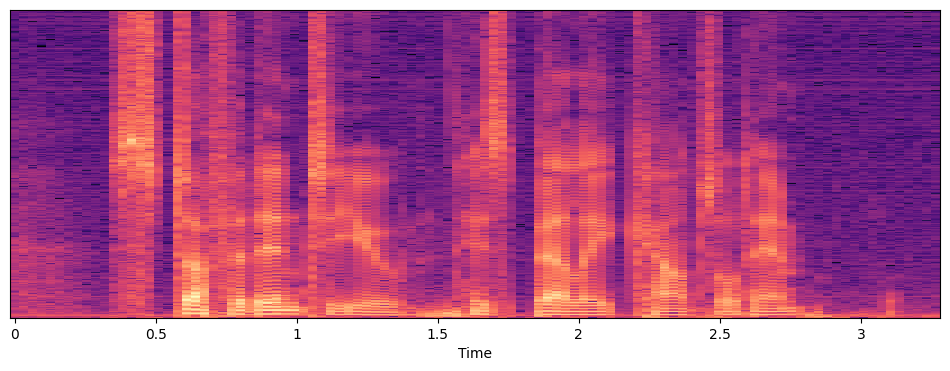

In [49]:
S = librosa.core.stft(audio_np, n_fft=1024, hop_length=512, win_length=1024)
D = np.abs(S)**2
log_S = librosa.power_to_db(S, ref=np.max) #소리의 단위를 db로 바꿈

plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=16000, x_axis='time')

### Window function?

위에서 Window function과 Window size라는 이야기가 나오고 있습니다. 윈도우 Function과 Size는 왜 쓰는 것이며 어떨때 쓰는 것일까요?

Window function의 주된 기능은 main-lobe의 width와 side-lobe의 레벨의 Trade-off 를 제어해 준다는 장점이 있습니다. 그리고 깁스 현상을 막아주는 고마운 친구이기도 하죠. 지금나온 main-lobe, side-bloe, 깁스현상은 무엇일까요?

In [50]:
def frame_audio(audio, FFT_size=1024, hop_size=20, sample_rate = 22050):
    audio = np.pad(audio, int(FFT_size/2), mode='reflect')
    frame_len = np.round(sample_rate*hop_size / 1000).astype(int)
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    frames = np.zeros((frame_num, FFT_size))

    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len+FFT_size]
    return frames

audio_framed = frame_audio(audio_np)
print("Framed audio shape: {}".format(audio_framed.shape))

Framed audio shape: (119, 1024)


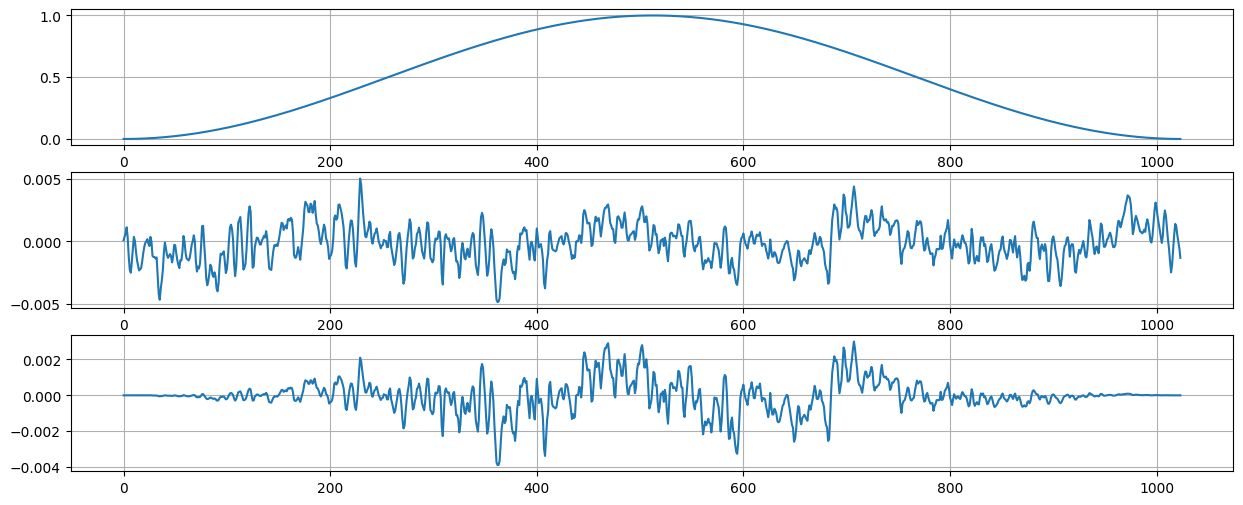

In [51]:
from scipy import signal

window = signal.get_window("hann", 1024, fftbins=True)
audio_win = audio_framed * window
ind = 2
plt.figure(figsize=(15,6))
plt.subplot(3,1,1)
plt.plot(window)
plt.grid(True)

plt.subplot(3,1,2)
plt.plot(audio_framed[ind])
plt.grid(True)

plt.subplot(3,1,3)
plt.plot(audio_win[ind])
plt.grid(True)
plt.show()

플롯을 보게 된다면 windowing을 적용하기전 plot은 끝부분이 다 다르지만, windowing을 지나고 나서 나오는 plot은 끝이 0 으로 일치한다는 특성을 볼 수 있습니다.

### Window size?

윈도우 사이즈는 일반적으로 time과 frequency의 resolutions을 제어해 줍니다.
- short-window : 낮은 frequency resolution, 높은 time-resolution을 가지게 됩니다.
- Long-window : 높은 frequency resolution을 가지며, 낮은 time-resolution을 가지게 됩니다.

### Spectrogram
Spectrogram을 추출하는 방법을 고민해봅시다.일반적으로 프로세스는 입력신호에 대해서 window function을 통과하여 window size만큼 sampling 된 data를 받아서 Discrete Fourier Transform을 거치게 됩니다. DFT를 거친 신호들은 Frequency와 Amplitude의 영역을 가지는 Spectrum이 됩니다. 이후 이를 90도로 회전시켜서, time domain으로 stack하게 됩니다.

Spectrogram은 Frequency Scale에 대해서 Scaling이 이루어집니다. 주파수 영역에 Scaling을 하는 이유는, 인간의 주파수를 인식하는 방식과 연관이 있습니다.

일반적으로 사람은, 인접한 주파수를 크게 구별하지 못합니다. 그 이유는 우리의 인지기관이 categorical한 구분을 하기 때문입니다. 때문에 우리는 주파수들의 Bin의 그룹을 만들고 이들을 합하는 방식으로, 주파수 영역에서 얼마만큼의 에너지가 있는지를 찾아볼 것입니다. 일반적으로는 인간이 적은 주파수에 더 풍부한 정보를 사용하기때문에, 주파수가 올라갈수록 필터의 폭이 높아지면서 고주파는 거의 고려를 안하게 됩니다.

따라서 아래 frequency scale은 어떤 방식을 통해 저주파수대 영역을 고려할 것이가에 대한 고민이 남아 있습니다.

### Linear frequency scale

일반적으로 single tone(순음)들의 배음 구조를 파악하기 좋습니다. 하지만 분포가 저주파수 영역에 기울어져(skewed) 있습니다.

### Mel Scale
멜 스펙트럼은 주파수 단위를 다음 공식에 따라 멜 단위로 바꾼 것을 의미합니다.

$$
m = 2595 \log_{10}\left(1 + \frac{f}{700}\right)
$$
일반적으로는 mel-scaled bin을 FFT size보다 조금더 작게 만드는게 일반적입니다.

In [52]:
# STFT
S = librosa.core.stft(audio_np, n_fft=1024, hop_length=512, win_length=1024)
# phase 에 대한 정보를 날린다.
D = np.abs(S)**2

In [53]:
# mel spectrogram (512 --> 40)
mel_basis = librosa.filters.mel(sr=sr, n_fft=1024, n_mels=40)
mel_S = np.dot(mel_basis, D)
mel_S.shape

(40, 103)

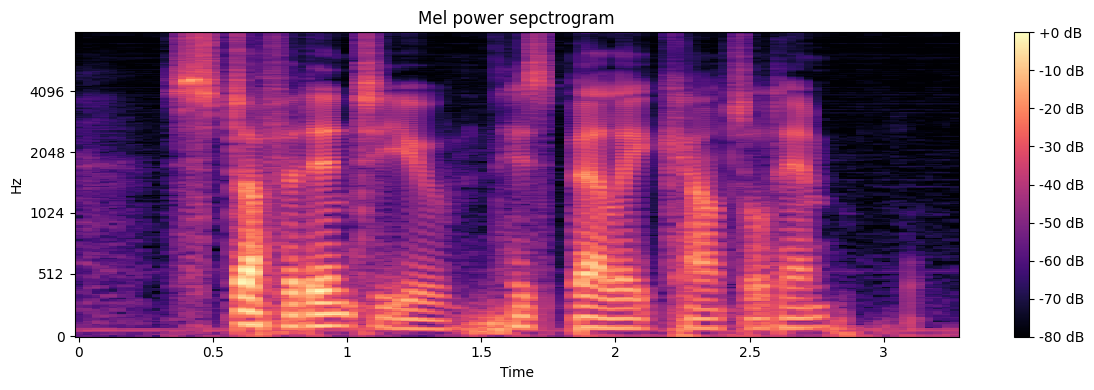

In [54]:
import librosa.display

S = librosa.feature.melspectrogram(y=audio_np, sr=sr, n_mels = 256)
log_S = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
plt.title('Mel power sepctrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()


### Bark scale
귀가 인식하는 주파수의 영역은 대략 $20Hz~2000Hz$로 가정합니다. 하지만 주파수에 대한 사람의 인식은 비선형적입니다. 귀와 뇌의 가청대역을 24개의 대역으로 나눈것을 Bark라고 합니다! Bark scale은 $500Hz$ 이하에서는 $100Hz$의 대역폭을 가지며, $500Hz$ 이상에서는 각 대역의 중심수파수의 대략 20%에 해당하는 대역폭을 가지게 됩니다.

`20, 100, 200, 300, 400, 510, 630, 770, 920, 1080, 1270, 1480, 1720, 2000, 2320, 2700, 3150, 3700, 4400, 5300, 6400, 7700, 9500, 12000, 15500 ( Hz )`

### Log compression

$$ 10 * log10(\frac{S}{ref})$$
의 단위로 신호를 스케일링 합니다. 이는 spectrogram을 데시벨 유닛으로 전환해 줍니다.

In [55]:
#log compression
log_mel_S = librosa.power_to_db(mel_S)
log_mel_S.shape

(40, 103)

### Discrete cosine transform (DCT)

DCT는 n개의 데이터를 n개의 코사인 함수의 합으로 표현하여 데이터의 양을 줄이는 방식입니다.

- 저 주파수에 에너지가 집중되고 고 주파수 영역에 에너지가 감소합니다.

Filter Bank는 모두 Overlapping 되어 있기 때문에 Filter Bank 에너지들 사이에 상관관계가 존재하기 때문이다. DCT는 에너지들 사이에 이러한 상관관계를 분리 해주는 역활을 해줍니다.

하지만 여기서 26개 DCT Coefficient 들 중 12만 남겨야 하는데, 그 이유는 DCT Coefficient 가 많으면, Filter Bank 에너지의 빠른 변화를 나타내게 되고, 이것은 음성인식의 성능을 낮추게 됩니다.

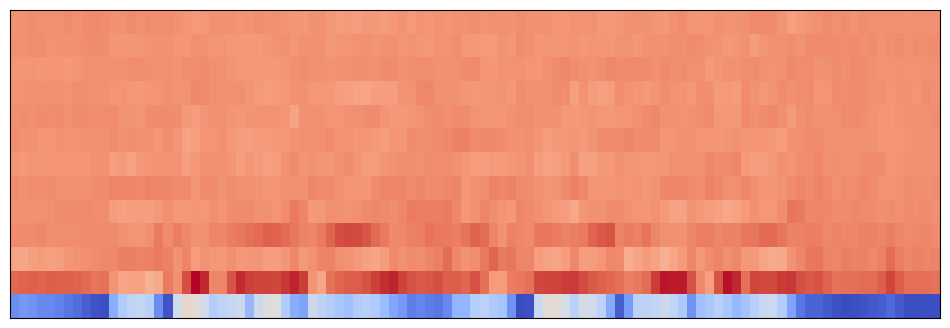

In [56]:
# mfcc (DCT)
mfcc = librosa.feature.mfcc(S=log_mel_S, n_mfcc=13)
mfcc = mfcc.astype(np.float32)    # to save the memory (64 to 32 bits)
plt.figure(figsize=(12,4))
librosa.display.specshow(mfcc)

(13, 103)


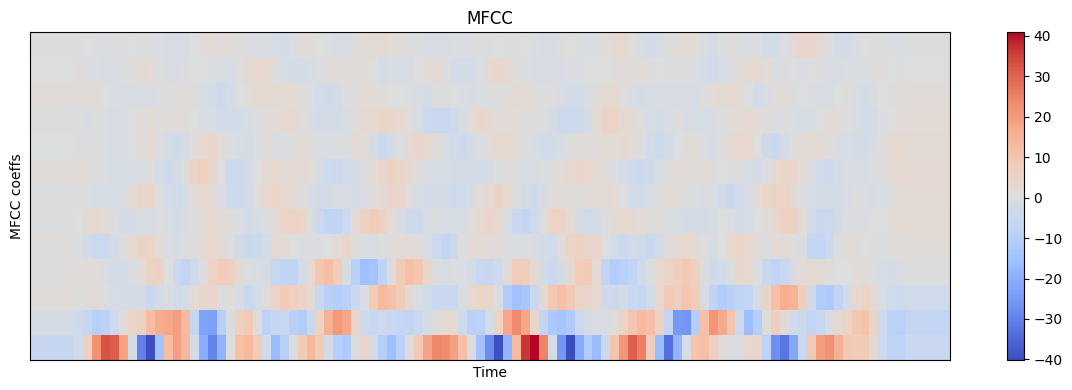

In [57]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)
print(delta2_mfcc.shape)

plt.figure(figsize=(12,4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [58]:
def change_pitch(data, sr):
    y_pitch = data.copy()
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change = pitch_pm * 2 * (np.random.uniform() - 0.5)
    y_pitch = librosa.effects.pitch_shift(y=y_pitch.astype('float64'), sr=sr, n_steps=pitch_change, bins_per_octave=bins_per_octave)
    return y_pitch

In [63]:
def waveform_aug(waveform,sr):
  y = change_pitch(waveform, sr)
  fig = plt.figure(figsize = (14,5))
  librosa.display.waveshow(y, sr=sr)
  ipd.display(ipd.Audio(data=y, rate=sr))
  return y, sr

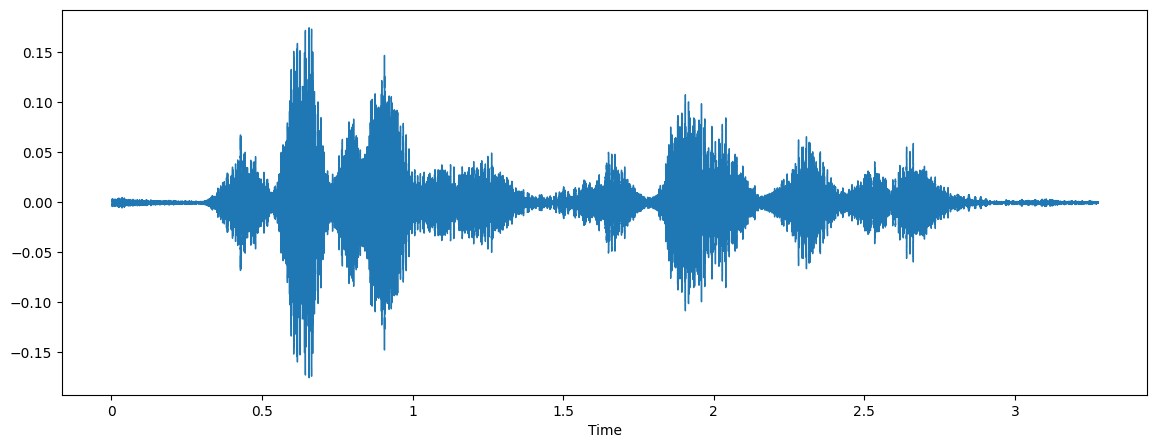

In [64]:
ipd.display(ipd.Audio(data=audio_np, rate=sr))
y, sr = waveform_aug(audio_np, 16000)

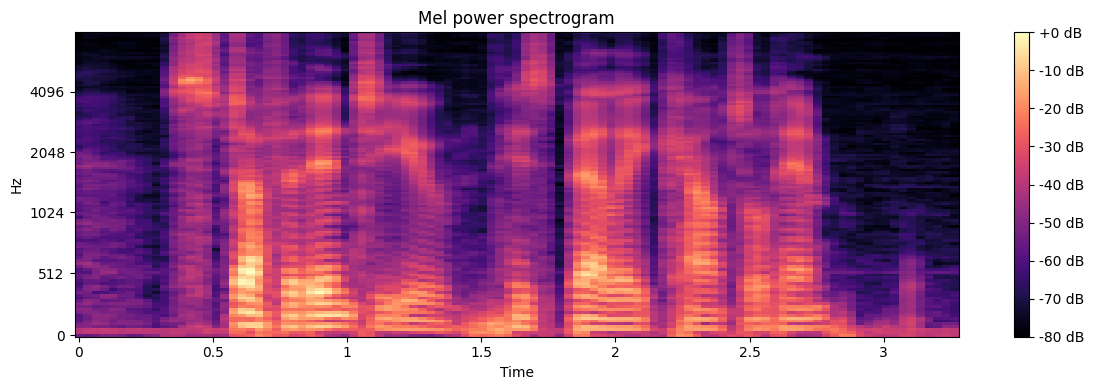

In [66]:
S = librosa.feature.melspectrogram(y=audio_np, sr=sr, n_mels=128)
log_S = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

In [67]:
np.random.uniform(low=1.5, high=3)

2.88216423232266

In [68]:
def value_aug(data):
    y_aug = data.copy()
    dyn_change = np.random.uniform(low=1.5, high=3)
    y_aug = y_aug * dyn_change
    return y_aug

In [69]:
def add_noise(data):
    noise = np.random.randn(len(data))
    data_noise = data + 0.005 * noise
    return data_noise

In [70]:
def hpss(data):
    y_harmonic, y_percussive = librosa.effects.hpss(data.astype('float64'))
    return y_harmonic, y_percussive

In [71]:
def shift(data):
    return np.roll(data, 1600)

In [72]:
def stretch(data, rate=1.0, sr=22050):
    # 1. STFT 변환
    D = librosa.stft(data)

    # 2. 시간 스트레칭 적용
    D_stretched = librosa.phase_vocoder(D, rate=rate, hop_length=512)

    # 3. ISTFT로 원래 시계열로 복원
    stretched = librosa.istft(D_stretched, hop_length=512)

    # 4. 원래 길이로 패딩/잘라내기
    input_length = len(data)
    if len(stretched) > input_length:
        stretched = stretched[:input_length]
    else:
        stretched = np.pad(stretched, (0, max(0, input_length - len(stretched))), "constant")

    return stretched


In [73]:
def change_pitch_and_speed(data):
    y_pitch_speed = data.copy()
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high=1)
    speed_fac = 1.0 / length_change
    tmp = np.interp(np.arange(0, len(y_pitch_speed), speed_fac), np.arange(0, len(y_pitch_speed)), y_pitch_speed)
    minlen = min(y_pitch_speed.shape[0], tmp.shape[0])
    y_pitch_speed *= 0
    y_pitch_speed[0:minlen] = tmp[0:minlen]
    return y_pitch_speed

In [74]:
data_noise = add_noise(audio_np)
data_roll = shift(audio_np)
data_stretch = stretch(audio_np)
pitch_speed = change_pitch_and_speed(audio_np)
value = value_aug(audio_np)
y_harmonic, y_percussive = hpss(audio_np)
y_shift = shift(audio_np)

In [75]:
ipd.Audio(data_noise, rate=fs)

In [76]:
train_audio_transforms = torch.nn.Sequential(
      torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=128),
      torchaudio.transforms.FrequencyMasking(freq_mask_param=15, iid_masks=False),
      torchaudio.transforms.TimeMasking(time_mask_param=35, iid_masks=False)
)

/home/elicer/anaconda3/envs/ME/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [77]:
masking_freq = train_audio_transforms(test_dataset[0][0])
masking_freq.shape


torch.Size([1, 128, 835])

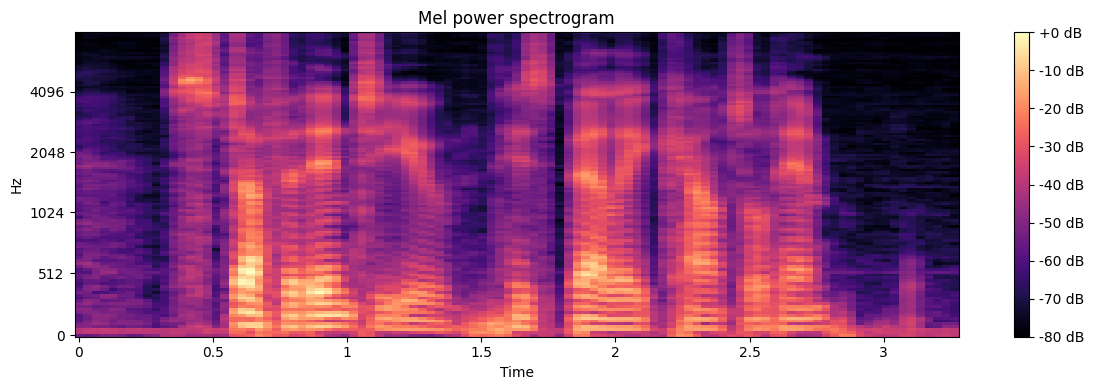

In [78]:
S = librosa.feature.melspectrogram(y=audio_np, sr=sr, n_mels=128)
log_S = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

### Make FIlter!

# 새 섹션

In [79]:
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt

def butter_pass(cutoff, fs, btype, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype=btype, analog=False)
    return b, a

def butter_filter(data, cutoff, fs, btype, order=5):
    b, a = butter_pass(cutoff, fs, btype, order=order)
    y = lfilter(b, a, data)
    return y

In [80]:
# Filter requirements.
order = 6
fs = 16000     # sample rate, Hz
cutoff = 2048  # desired cutoff frequency of the filter, Hz

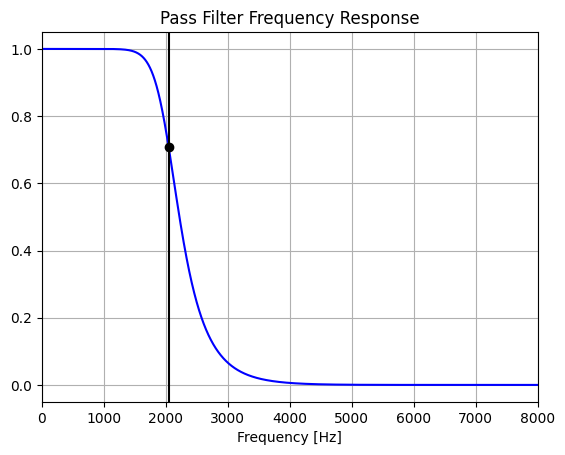

In [81]:
# Get the filter coefficients so we can check its frequency response.
b, a = butter_pass(cutoff, fs, 'lowpass',order)

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)

plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Pass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

In [82]:
T = len(audio_np)/sr   # seconds
n = int(T * sr) # total number of samples
t = np.linspace(0, T, n, endpoint=False)

# Filter the data, and plot both the original and filtered signals.
y = butter_filter(audio_np, cutoff, fs, 'lowpass', order)
ipd.Audio(y, rate=fs)

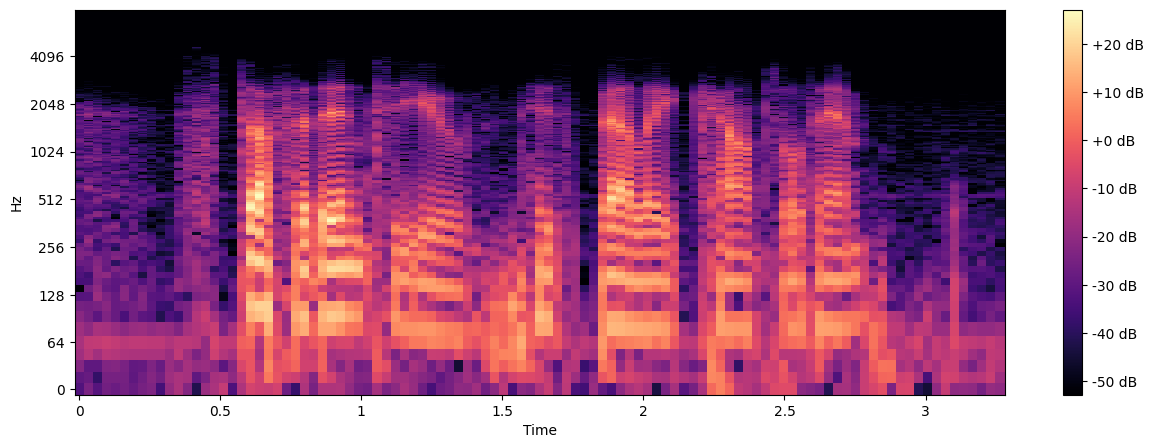

In [83]:
X = librosa.core.stft(y, n_fft=1024, hop_length=512, win_length=1024) # get frequency to STFT
S = librosa.amplitude_to_db(abs(X)) # Change Amplitude to decibel
plt.figure(figsize=(15, 5)) # get figure size
librosa.display.specshow(S, sr=fs, hop_length=512, x_axis='time', y_axis='log') #display
plt.colorbar(format='%+2.0f dB')

In [84]:
test_dataset[0]

(tensor([[0.0003, 0.0003, 0.0004,  ..., 0.0021, 0.0021, 0.0016]]),
 16000,
 'HE HOPED THERE WOULD BE STEW FOR DINNER TURNIPS AND CARROTS AND BRUISED POTATOES AND FAT MUTTON PIECES TO BE LADLED OUT IN THICK PEPPERED FLOUR FATTENED SAUCE',
 1089,
 134686,
 0)

In [85]:
import torch.nn as nn

train_audio_transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=128),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
    torchaudio.transforms.TimeMasking(time_mask_param=35)
)

valid_audio_transforms = torchaudio.transforms.MelSpectrogram()

In [86]:
import numpy as np
from torch.utils.data import Dataset, DataLoader

class CustomAudioDataset(Dataset):
    def __init__(self, data_list, labels, transform=None):
        self.data = data_list
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

In [87]:
from torch.utils.data import DataLoader, random_split

def get_dataloader(dataset, batch_size=32, valid_ratio=0.2):
    val_size = int(len(dataset) * valid_ratio)
    train_size = len(dataset) - val_size
    train_set, val_set = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    return train_loader, valid_loader

In [88]:
data_list = [torch.randn(1, 16000) for _ in range(100)]  # 1초짜리 wave 100개
labels = [torch.randint(0, 10, (1,)).item() for _ in range(100)]

# Dataset 인스턴스
test_dataset = CustomAudioDataset(data_list, labels, transform=None)

# Dataloader 생성
train_loader, valid_loader = get_dataloader(test_dataset)